Para contruirmos o sistema de recomendação utilizando o algoritmo de Naive Bayes, usamos principalmente as bibliotecas "sklearn" e "pandas" para manipular as planilhas de dados

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB

Agora vamos organizar os dados, primeiro carregando eles com o pd.read_csv() e em seguida já fazendo a média das classificações por usuario do arquivo 'ratings_small.csv', por fim mostramos o resultado de average_ratings com o número de avaliações

In [9]:
# Carregue o conjunto de dados
df = pd.read_csv('movies_metadata.csv')
ratings_df = pd.read_csv('ratings_small.csv')

# Engenharia de Recursos: Calcula a média das classificações de usuários por filme
average_ratings = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
average_ratings.rename(columns={'mean': 'average_rating', 'count': 'num_ratings'}, inplace=True)
display(average_ratings.head(10))

C:\Users\lucas\AppData\Local\Temp\ipykernel_12176\994789551.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')


movieId  average_rating  num_ratings
0        1        3.872470          247
1        2        3.401869          107
2        3        3.161017           59
3        4        2.384615           13
4        5        3.267857           56
5        6        3.884615          104
6        7        3.283019           53
7        8        3.800000            5
8        9        3.150000           20
9       10        3.450820          122

Eliminaremos os filmes com menos de 20 avaliações, e por fim juntamos fazemos uma junção de tabela com inner join, que eliminará filmes sem avaliações em 'ratings_small.csv'

In [10]:
# Filtrar os filmes com pelo menos 20 avaliações
average_ratings = average_ratings[average_ratings['num_ratings'] >= 20]



# Remover entradas que não são convertíveis em inteiros
df = df[df['id'].str.isnumeric()]

# Converter a coluna 'id' para int64
df['id'] = df['id'].astype('int64')

# Combinar os dados de filmes com as médias das avaliações
df = df.merge(average_ratings, left_on='id', right_on='movieId', how='inner')

A seguir teremos que organizar o X_combined para que seja usado na função train_test_split que criará os dados para o conjunto de treinamento e teste

In [11]:
# Função para atribuir rótulos com base nos gêneros
def assign_genre_labels(genres):
    target_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Drama']
    
    genre_list = eval(genres)  # Converte a string de gêneros em uma lista de dicionários
    
    # Cria uma lista com os gêneros presentes no filme
    labels = [genre['name'] for genre in genre_list if genre['name'] in target_genres]
    
    return labels

# Aplicar a função para obter as labels em formato de lista
df['label'] = df['genres'].apply(assign_genre_labels)

# Converter a lista de listas em uma matriz binária
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['label'])

# Definir os nomes das colunas
genre_keywords = ['Action', 'Adventure', 'Animation', 'Comedy', 'Drama']

# Criar um DataFrame
X_df = pd.DataFrame(X, columns=genre_keywords)

# Concatenar com a coluna de avaliação média
X_combined = pd.concat([X_df, df['average_rating']], axis=1)
display(X_combined.head(10))

Action  Adventure  Animation  Comedy  Drama  average_rating
0       1          1          0       0      0        3.616279
1       0          0          0       0      1        3.555556
2       0          0          0       1      0        3.267857
3       0          1          0       0      0        3.590909
4       0          0          0       0      1        2.743421
5       0          0          0       1      1        2.380000
6       0          0          0       1      1        3.223404
7       0          0          0       0      1        2.911765
8       0          0          0       0      0        3.880000
9       1          1          0       0      0        3.689024

Reorganizamos o df['label'] para que consigamos usa-lo em train_test_split também, em seguida criando as variáveis X_train, X_test, y_train e y_test.

In [12]:
# Função para atribuir rótulos com base nos gêneros
def assign_genre_label(genres):
    target_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Drama']
    
    genre_list = eval(genres)  # Converte a string de gêneros em uma lista de dicionários
    
    for genre in genre_list:
        if genre['name'] in target_genres:
            return genre['name']
    
    return 'Other'
    
# Atribuir rótulos aos filmes com base em gêneros
df['label'] = df['genres'].apply(assign_genre_label)

    
# Dividir os Dados em Conjunto de Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['label'], test_size=0.2, random_state=42)

Treinaremos o modelo Naive Bayes e faremos a acurácia do mesmo

In [13]:
# Treinar o modelo Naive Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

# Acurácia do Modelo
accuracy = naive_bayes_model.score(X_test, y_test)
print(f'Acurácia do Modelo: {accuracy:.2f}')

Acurácia do Modelo: 0.74


Fazemos a previsão de um gênero e de acordo com ele e as avaliações, indicaremos 10 filmes

In [14]:
# Criar um vetorizador de gêneros
vectorizer = CountVectorizer(vocabulary=genre_keywords)

# Fazer uma previsão
sample_genre_vector = mlb.transform([['Action', 'Adventure', 'Drama']])  # Gêneros do exemplo
sample_genre_vector_with_rating = np.append(sample_genre_vector, [[3.5]], axis=1)  # Adicionar a avaliação média

predicted_genre = naive_bayes_model.predict(sample_genre_vector_with_rating)
print(f'Gênero Previsto: {predicted_genre[0]}')

# Recomendar filmes com base no gênero previsto
recommended_movies = df[df['label'] == predicted_genre[0]].head(10)
print('Filmes Recomendados:')
print(recommended_movies[['title', 'genres']])

Gênero Previsto: Action
Filmes Recomendados:
                            title  \
0                Cutthroat Island   
13         Star Trek: Generations   
19  Faster, Pussycat! Kill! Kill!   
20          Beverly Hills Cop III   
23                    Hard Target   
24                 Judgment Night   
28              Romeo Is Bleeding   
30                   True Romance   
31     Terminator 2: Judgment Day   
46                   The 39 Steps   

                                               genres  
0   [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...  
13  [{'id': 878, 'name': 'Science Fiction'}, {'id'...  
19  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  
20  [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...  
23  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...  
24  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...  
28  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  
30  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...  
31  [{'id': 28, 'name': 'Action'}, {'id': 5

c:\Users\lucas\Desktop\UnB\8semestre\Introducão a inteligência artificial\Trab1\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


Agora calcularemos as métricas finais para cada gênero de filme.

In [15]:
# Fazer previsões no conjunto de teste
y_pred = naive_bayes_model.predict(X_test)

# Calcular precisão, revocação, F1 e suporte para cada gênero
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=genre_keywords)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)

# Imprimir as métricas para cada gênero
print('Métricas para cada gênero:')
for i, genre in enumerate(genre_keywords):
    print(f'Gênero: {genre}')
    print(f'  Precisão: {precision[i]:.2f}')
    print(f'  Revocação: {recall[i]:.2f}')
    print(f'  F1: {f1[i]:.2f}')
    print(f'  Suporte: {support[i]}')
    print()

Métricas para cada gênero:
Gênero: Action
  Precisão: 0.59
  Revocação: 0.77
  F1: 0.67
  Suporte: 13

Gênero: Adventure
  Precisão: 0.67
  Revocação: 0.36
  F1: 0.47
  Suporte: 11

Gênero: Animation
  Precisão: 1.00
  Revocação: 0.50
  F1: 0.67
  Suporte: 2

Gênero: Comedy
  Precisão: 0.92
  Revocação: 0.96
  F1: 0.94
  Suporte: 23

Gênero: Drama
  Precisão: 0.73
  Revocação: 0.95
  F1: 0.82
  Suporte: 56



Por fim temos o preparo e a amostragem da curva ROC para os 5 generos escolhidos

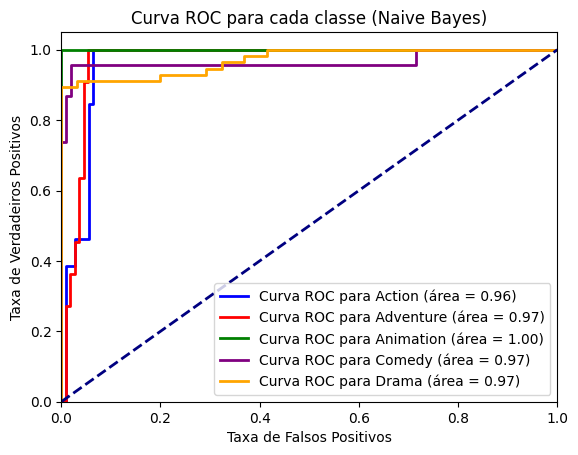

In [16]:
# Calcular a curva ROC para cada classe (one-vs-rest)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(genre_keywords)):
    y_test_binary = y_test.apply(lambda x: 1 if x == genre_keywords[i] else 0)
    y_score = naive_bayes_model.predict_proba(X_test)[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar a curva ROC para cada classe
plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i in range(len(genre_keywords)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Curva ROC para {genre_keywords[i]} (área = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para cada classe (Naive Bayes)')
plt.legend(loc='lower right')
plt.show()